In [91]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from obspy.signal.konnoohmachismoothing import calculate_smoothing_matrix
from obspy.signal.konnoohmachismoothing import apply_smoothing_matrix
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

import awp_processing
# tight_layout() only considers ticklabels, axis labels, and titles. Thus, other artists may be clipped and also may overlap.
# [left, bottom, right, top] in normalized (0, 1) figure coordinates
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 1.5}
plt.rcParams.update({'figure.dpi': 200})
sns.set(context='paper', style='whitegrid', font_scale=1, rc={"xtick.bottom" : True, "ytick.left" : True})


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [2]:
def adjust_prop_1d(bore_profile, bore_depth, dh, data, bedrock_depth):
    data_out = data.copy()
    for k in range(len(data)):      
        depth = np.searchsorted(bore_depth, k * dh)
        if k * dh >= bedrock_depth:
            depth = max(2, depth)
        data_out[k] = bore_profile[depth]  
    return data_out

def adjust_prop_3d(bore_profile, bore_depth, dh, data, bedrock_depth):
    z, y, x = data.shape
    data_out = data.copy()
    for i in range(x):
        for j in range(y):
            data_out[:, j, i] = adjust_prop_1d(bore_profile, bore_depth,
                                dh, data[:, j, i], bedrock_depth[j, i])
    return data_out

In [3]:
def estimateRhofromVs(vs):
    N = len(vs)
    rho = np.zeros(N)
    for i in range(N):
        if vs[i] <= 333:
            rho[i] = 2000 + 190 * (vs[i] - 166.5) / 333
        elif vs[i] < 560:
            rho[i] = 2350
        elif vs[i] < 640:
            rho[i] = 2450
        else:
            rho[i] = 2750
    return rho


def estimateQfromVs(vs):
    N = len(vs)
    q = np.zeros(N)
    for i in range(N):
        if vs[i] <= 1000:
            q[i] = 0.06 * vs[i]
        elif vs[i] < 2000:
            q[i] = 0.04 * vs[i]
        else:
            q[i] = 0.16 * vs[i]
    return q

In [4]:
def SH1D(vs, h, f, theta=0, qs=[], rho=[]):
    """Compute SH1D
    Input:
        vs ([float]): 1D array (N) listing vs in each layer, beginning with the uppermost
        h ([float]): 1D array (N-1) of thickness of each layer
        f ([float]): frequency range
        theta (float): incident angle (0-90), 0-vertical
        qs ([float]): Attenuation
        rho ([float]): density
    """
    if not len(qs):
        qs = estimateQfromVs(vs)
    # qs = [0.05 * i for i in vs]
    #qs = [1e14 for i in vs]
    if not len(rho):
        rho = estimateRhofromVs(vs)
    N = len(vs)
    theta = np.radians(theta)
    ga = np.ones(N) - 0.5j * np.ones(N) / qs
    p = np.sin(theta) / vs[-1]
    eta = ((np.ones(N - 1) / (vs[:-1] * ga[:-1]) ** 2) - p ** 2 * np.ones(N - 1)) ** 0.5
    Im = rho * vs * ga
    r = (Im[1:] - Im[:-1]) / (Im[1:] + Im[:-1])
    t = 2 * Im[1:] / (Im[0:-1] + Im[1:])
    tau = eta * h
    factor = 1
    S11, S22, S12, S21 = 1, 1, 0, 0
    for k in range(N - 1):
        factor = factor * t[k]
        A11 = np.exp(-1j * 2 * np.pi * tau[k] * f)
        A12 = r[k] * np.exp(1j * 2 * np.pi * tau[k] * f)
        A21 = r[k] * np.exp(-1j * 2 * np.pi * tau[k] * f)
        A22 = np.exp(1j * 2 * np.pi * tau[k] * f)
        Stmp11 = A11 * S11 + A12 * S21
        Stmp21 = A21 * S11 + A22 * S21
        Stmp12 = A11 * S12 + A12 * S22
        Stmp22 = A21 * S12 + A22 * S22
        S11 = Stmp11
        S12 = Stmp12
        S21 = Stmp21
        S22 = Stmp22
    amp = np.abs(factor * np.ones(len(f)) / (S11 + S12))
    return amp


In [41]:
def comp_TTF(C, ix, iy, iz, lowf=0.5, highf=12, smoother=[]):
    """Compute TTF using horizontal velocity components
    Input:
        C (class): awp_scenario
        ix, iy, iz (int): site location index, 1-indexed
        
    11.2 Hz exactly
    """
    fv_top = C.comp_spec(ix, iy, 1, lowf=lowf, highf=highf)
    fv_bot = C.comp_spec(ix, iy, iz, lowf=lowf, highf=highf)
    fa_top = np.sqrt(fv_top.x ** 2 + fv_top.y ** 2)
    fa_bot = np.sqrt(fv_bot.x ** 2 + fv_bot.y ** 2)
    if not len(smoother):
        smoother = calculate_smoothing_matrix(fv_top, normalize=True)
    ttf = apply_smoothing_matrix(fa_top / fa_bot, smoother, 1)
    f = fv_top['f']
    return np.rec.fromarrays([ttf, f], names='ttf, f')

In [93]:
C = awp_processing.analyze.Scenario(model="toy")
C_x = awp_processing.analyze.Scenario(model="toy", case='x')  # X_component source
C_f = awp_processing.analyze.Scenario(model="toy", case='f')  # play with Q(f)
C_stf = awp_processing.analyze.Scenario(model="toy", case='stf')  # ricker wavelet source
#fv = C.comp_spec(40, 40, 1, highf=12)

In [94]:
# sm_ref = calculate_smoothing_matrix(fv.f, normalize=True)
# res = comp_TTF(C, 40, 41, 20, lowf=0.1, highf=12, smoother=sm_ref)
# res_stf = comp_TTF(C_stf, 40, 41, 20, lowf=0.1, highf=12, smoother=sm_ref)
res_f = comp_TTF(C_f, 40, 41, 20, lowf=0.1, highf=12, smoother=sm_ref)

ix=0, iy=1, iz=0
ix=0, iy=1, iz=1


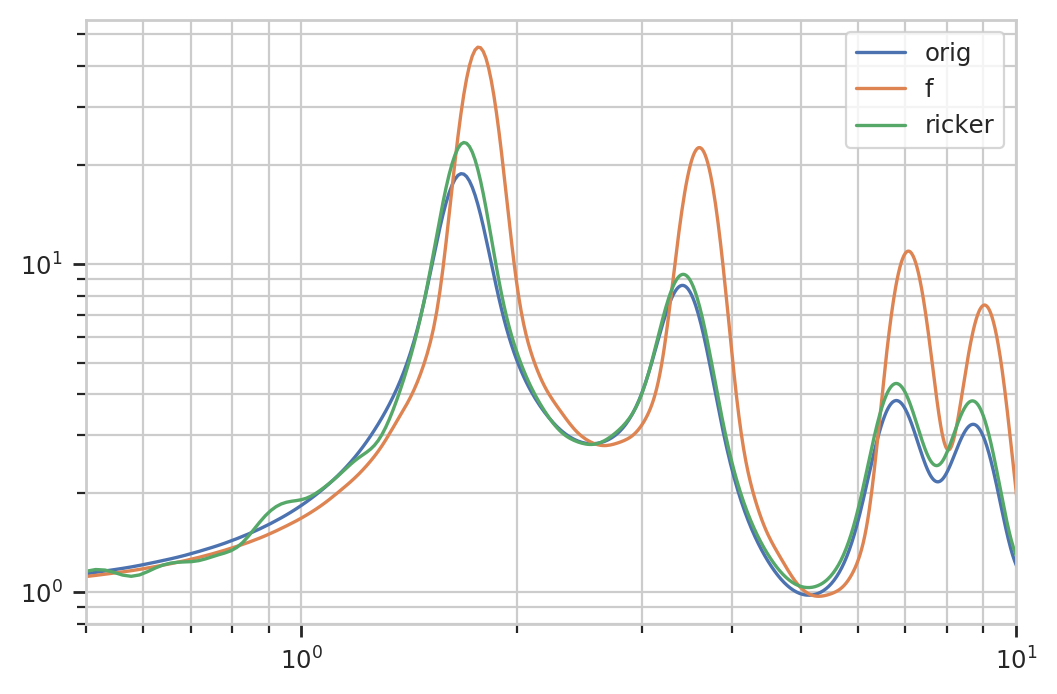

In [95]:
plt.loglog(res.f, res.ttf, label='orig')
plt.loglog(res_f.f, res_f.ttf, label='f')
plt.loglog(res_stf.f, res_stf.ttf, label='ricker')
plt.xlim(0.5, 10)
plt.grid('on', which='both')
plt.legend()

iy: rounded using nearest grid
ix=0, iy=1, iz=0


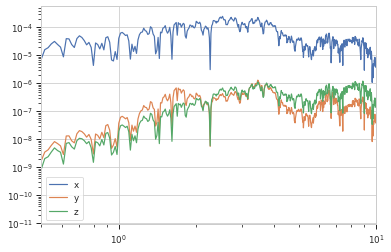

In [45]:

fv = C_x.comp_spec(40, 40, 1, comps='xyz', highf=12)
#plt.loglog(fv.f, apply_smoothing_matrix(fv.x, sm_ref, 1))
plt.loglog(fv.f, fv.x, label='x')
plt.loglog(fv.f, fv.y, label='y')
plt.loglog(fv.f, fv.z, label='z')
plt.xlim(0.5, 10)
plt.legend()

[1.         1.83863374 3.2638421  4.20228922 1.55766889]


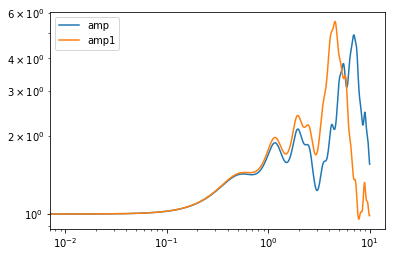

In [27]:
# TKCH05 profile
vs = [140, 680, 1100, 1400, 1700]
h = [5, 92.5, 195, 472.5]
h1 = [7.5, 92.5, 195, 472.5]
f = np.arange(0, 10.001, 0.01)
theta = 0
amp = SH1D(vs, h, f)
amp1 = SH1D(vs, h1, f)
print(amp[::250])
plt.loglog(f, amp, label='amp')
plt.loglog(f, amp1, label='amp1')
plt.legend()

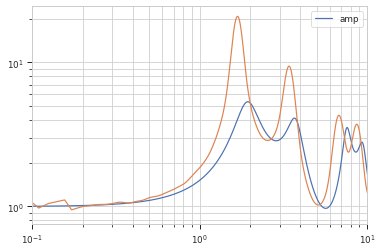

In [58]:
data_dir = "/ccs/home/hzfmer/file_back/preevents"

bore_vs = np.array([220, 560, 1700, 3000])
bore_vp = np.array([1500, 2000, 2800, 5200])
bore_ro = np.array([2100, 2350, 2750, 2750])
bore_qs = 0.05 * bore_vs
bore_qp = 2 * bore_qs

h = [20, 48]
vs = [220, 560, 1700]
f = np.arange(0, 20.001, 0.01)
theta = 0
amp = SH1D(vs, h, f)
plt.loglog(f, amp, label='amp')
plt.loglog(res.f, res.ttf)
plt.xlim(0.1, 10)
plt.legend()
plt.grid('on', which='both')

In [48]:
nx, ny, nz = 80, 80, 100
dh = 4
h = [20, 64, 220]


bore_vs = np.array([220, 560, 1700])
bore_vp = np.array([1500, 2000, 2800])
bore_ro = np.array([2100, 2350, 2750])
bore_qs = 0.05 * bore_vs
bore_qp = 2 * bore_qs
h = [20, 68]

vp = adjust_prop_1d(bore_vp, h, dh, np.zeros(nz,), 400)
vp = np.tile(vp, [nx, ny, 1]).swapaxes(0, 2)
vs = adjust_prop_1d(bore_vs, h, dh, np.zeros(nz,), 400)
vs = np.tile(vs, [nx, ny, 1]).swapaxes(0, 2)
ro = adjust_prop_1d(bore_ro, h, dh, np.zeros(nz,), 400)
ro = np.tile(ro, [nx, ny, 1]).swapaxes(0, 2)
qs = 0.05 * vs
qp = 2 * qs

dat = np.vstack(list(map(np.ravel, (vp, vs, ro, qp, qs)))).T.astype('f')
dat.tofile(Path('toy','mesh_toy_4m_1d.bin'))

print(amp[::250])

[1.         3.64844359 1.37541156 3.26702059 3.32938869]


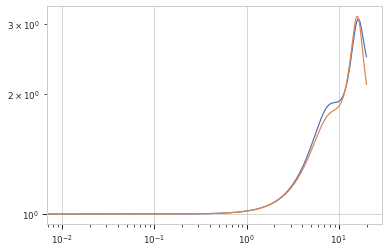

In [56]:
h = [6, 8, 26, 20]
vs = [510, 880, 1400, 1700, 2100]
qs = [0.05 * i for i in vs]
f = np.arange(0, 20.001, 0.01)
amp = SH1D(vs, h, f, qs=qs)
plt.loglog(f, amp, label='amp')

nrattle = np.genfromtxt('toy/OKYH07.out', skip_header=19)
plt.loglog(nrattle[:, 0], nrattle[:, 2])

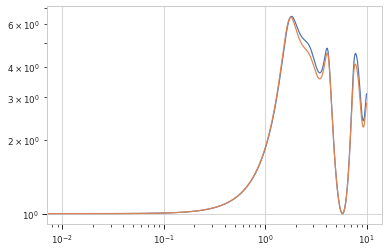

In [54]:
h = [20, 44, 156]
vs = [220, 560, 1700, 3000]
f = np.arange(0, 10.001, 0.01)
amp = SH1D(vs, h, f)
plt.loglog(f, amp, label='amp')

nrattle = np.genfromtxt('toy/nrattle.out', skip_header=19)
plt.loglog(nrattle[:, 0], nrattle[:, 2])

### Mesh

In [11]:
nx, ny, nz = 80, 80, 100
aa = np.fromfile(Path('toy','mesh_toy_4m_1d.bin'), dtype='f').reshape(nz, ny, nx, 5)[:, :, 0, 1]

220.0 1700.0


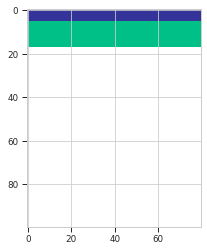

In [12]:
plt.imshow(aa, cmap='terrain')
print(aa.min(), aa.max())

In [13]:
print(aa[:, 0])

[ 220.  220.  220.  220.  220.  220.  560.  560.  560.  560.  560.  560.
  560.  560.  560.  560.  560.  560. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 1700.]


### Source

Source generated from recorded time series (I recalled), which shows enough high frequency information

In [61]:
def func_ricker(t, fc, t0):
    F = (np.pi * fc * (t - t0)) ** 2
    return (1 - 2 * F) * np.exp(-F)

In [79]:
dt = 0.00032
nt = 200000
t = np.arange(nt) * dt
src_ricker = func_ricker(t, 10, 10)
src_ricker = np.tile(src_ricker[:, np.newaxis], (1, 3))
for i in range(3):
    rand = np.random.rand(nt, )
    rand /= np.sum(rand)
    src_ricker[:, i] *= rand
    
np.savetxt('toy/stf_ricker.txt', src_ricker, fmt='%.5f')

# stf = np.genfromtxt('toy/stf_ricker.txt', usecols=(0))
# f_stf = np.abs(np.fft.fft(stf) * dt)
# f = np.arange(len(stf)) * (1 / dt / len(stf))
# #plt.loglog(f, f_stf)
# #plt.xlim(0.1, 30)
# plt.plot(np.arange(len(stf)) * dt, stf)

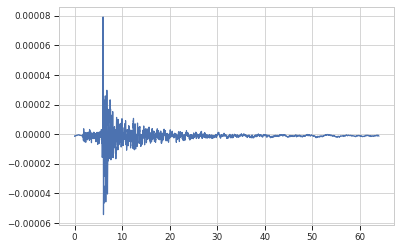

In [49]:
plt.plot(np.arange(len(stf)) * dt, stf)